## Goal

* Extract country specific restriction from NOTAMs. Identify passenger/flights from which countries are allowed to land in a country

    
    - The following is a NOTAM from one of the airspaces in Hungary:
    
            arrival entry at hungarian airports is allowed only for hungarian citizens and citizens of andorra, austria, belgium, cyprus, czechia, denmark, estonia, finland, france, greece, netherlands, croatia, ireland, iceland, polen, latvia, lichtenstein, lithuania, luxembourg, malta, monaco, germany, italy, san marino, spain, switzerland, slovakia, slovenia and vatican.
            
            
### Tasks and Challenges

* Identify mention of countries or group of countries, etc in the message and tag it!

    - Country mentioned using multiple abbreviations, aliases (example: U.S.A, U.S., United States)
    
    - Mention of group of countries like European Union, Schengen, Latin America, Carribean, etc


* Extract the meaning of the sentence 

    - Identify the type - entry closed to the mentioned countries or open to the mentioned countries or some exceptions apply
    
    - In some cases the airport is closed to all flights. This should also be captured as closed to all countries
    
    - In some cases the sentence contains information about countries allowed and that are not allowed and it has to be discerned!

#### NOTE:

The results in this notebook cannot be directly reproduced. The input data has to be downloaded by the user!

We read in the NOTAMS data downloaded from https://www.icao.int/safety/iStars/Pages/API-Data-Service.aspx. The data will not be published on this site and has to be downloaded by each user on their own to carry out the following analysis. In order to download the data, the user must register on https://www.icao.int/safety/iStars/Pages/API-Data-Service.aspx to get a free API key.

Once the data is downloaded the notebook, run the notebook - "ws2_snr_NOTAMs_1_data_preparation" to get the input file


In [ ]:
try:
    import spacy
except:
    !pip install spacy
try:
    import spacy_langdetect
except:
    !pip install spacy-langdetect
try:
    import flair
except:
    !pip install flair
try:
    import geonamescache
except:
    !pip install geonamescache
try:
    import spacy_fastlang
except:    
    !pip install spacy_fastlang
    #!pip install sense2vec==1.0.0a1
try:
    import gensim
except:
    !pip install gensim
try:
    import wordcloud
except:
    !pip install wordcloud
try:
    import nltk
except:
    !pip install nltk

try:
    import visualise_spacy_tree
except:
    !pip install visualise-spacy-tree

try:
    import textacy
except:
    !pip install textacy

!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

In [ ]:
import pandas as pd

import requests
import plac
import spacy
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.pipeline import EntityRuler
from spacy.pipeline import merge_entities
import csv
import re
import ast
from langdetect import detect
import numpy as np

from nltk.tokenize import sent_tokenize
import nltk
nltk.download("punkt")
import visualise_spacy_tree
import textacy

from IPython.display import Image,display

### 1. Identify mention of countries or group of countries, etc in the message and tag it!

- Identification of country names in NOTAMS:


    - Collect all the aliases of country names
    - Create a pattern to tag it with the country code as the id
    - As some countries have more than single word, merge country names to single entity

In [4]:
all_countries = pd.read_csv("/project_data/data_asset/all_countries_with_aliases.csv")

In [5]:
all_countries.head()

,Country Code,Name,Path,Aliases,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,AD,Andorra,NaN,AD # Kneževina Andora # Πριγκιπάτο της Ανδόρας...,Andorra,AD,AND,20,ISO 3166-2:AD
1,AE,United Arab Emirates,NaN,AE # الإمارات العربية المتحدة # ΗΑΕ # Forened...,United Arab Emirates,AE,ARE,784,ISO 3166-2:AE
2,AF,Afghanistan,NaN,AF # افغانستان # Афганистан # Repubblica Islam...,Afghanistan,AF,AFG,4,ISO 3166-2:AF
3,AG,Antigua and Barbuda,NaN,AG # Antigua e Barb. # Antigua und Barbuda # แ...,Antigua and Barbuda,AG,ATG,28,ISO 3166-2:AG
4,AI,Anguilla,NaN,AI # 安圭拉 # Ангилья # Ангильа аралы # Ανγκουίλα...,Anguilla,AI,AIA,660,ISO 3166-2:AI


In [6]:
all_countries_aliases = dict()
for idx, r in all_countries[~all_countries.Aliases.isna()].iterrows():
    a = dict()
    a['alpha_2_code'] = r['Alpha-2 code']
    a['alpha_3_code'] = r['Alpha-3 code']
    a['name'] = r['Name']
    all_countries_aliases.update({r['Name'].lower():a})
    
    cnames = r['Aliases'].split(' # ')
    if len(cnames) > 0:
        for c in cnames:
            if len(c.strip())>3:
                a = dict()
                a['alpha_2_code'] = r['Alpha-2 code']
                a['alpha_3_code'] = r['Alpha-3 code']
                a['name'] = r['Name']
                all_countries_aliases.update({c.strip().lower():a})

In [7]:
all_patterns = list()
for k in all_countries_aliases.keys():
    c_patterns = k.split()

    
    c_patterns_list = []
    for c in c_patterns:
        d = dict()
        d['LOWER'] = c
        c_patterns_list.append(d)
    
    
    pattern_dict = dict()
    pattern_dict["label"] = "GPE"
    pattern_dict["pattern"] = c_patterns_list
    pattern_dict["id"] = all_countries_aliases[k]['alpha_3_code']
    
    all_patterns.append(pattern_dict)

In [8]:
eu = ["Belgium",
    "Bulgaria",
    "Denmark",
    "Germany",
    "Estonia",
    "Finland",
    "France",
    "Greece",
    "Ireland",
    "Italy",
    "Croatia",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Austria",
    "Poland",
    "Portugal",
    "Romania",
    "Sweden",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Czech Republic",
    "Hungary",
    "United Kingdom",
    "Cyprus"]

eea_c = eu+[
    "Iceland",
    "Liechtenstein",
    "Norway","Switzerland"
]

schengen = ["Austria", "Belgium", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Italy", "Latvia",
            "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Norway", "Poland", "Portugal", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland"]

scandinavian = ["Denmark","Norway","Sweden"]

eum = []
for c in eu:
    #print(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])
    eum.append(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])

eea = []
for c in eea_c:
    #print(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])
    eea.append(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])

sch = []
for c in schengen:
    #print(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])
    sch.append(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])

svc = []
for c in scandinavian:
    #print(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])
    svc.append(all_countries[all_countries['Name'].str.contains(c)]['Alpha-3 code'].values[0])
    
neum = list(set(all_countries['Alpha-3 code'].unique()).difference(set(eum)))
nsch = list(set(all_countries['Alpha-3 code'].unique()).difference(set(sch)))
neu = list(set(all_countries['Alpha-3 code'].unique()).difference(set(eea)))

Creating patterns to identify group of countries such as European Union, etc and add it to entity ruler so that mention of such words would be captured as GPE 

In [9]:
all_patterns.extend([{'label': 'GPE',
  'pattern': [{'LOWER': 'republic'}, {'LOWER': 'of'}, {'LOWER': 'costarica'}],
  'id': 'CRI'},
  {'label': 'GPE',
  'pattern': [{'LOWER': 'saint'}, {'LOWER': 'christopher'}, {'LOWER': 'and'}, {'LOWER': 'nevis'}],
  'id': 'KNA'}, 
{'label': 'GPE',
  'pattern': [{'LOWER': 'vatican'}, {'LOWER': 'city'}],
  'id': 'VAT'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'vatican'}],
  'id': 'VAT'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'member'}, {'LOWER': 'states'}, {'LOWER': 'of'},{'LOWER': 'the'}, {'LOWER': 'european'}, {'LOWER': 'union'}],
  'id': 'EUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'eu'}, {'LOWER': 'member'}, {'LOWER': 'state'}],
  'id': 'EUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'european'}, {'LOWER': 'union'}, {'LOWER': 'member'}, {'LOWER': 'states'}],
  'id': 'EUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'european'}, {'LOWER': 'union'}],
  'id': 'EUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'eu'}, {'LOWER': 'member'}, {'LOWER': 'states'}],
  'id': 'EUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'eu'}],
  'id': 'EUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'schengen'}],
  'id': 'SCH'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'south-korea'}],
  'id': 'KOR'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'uk'}],
  'id': 'GBR'},
 {'label': 'GPE',
  'pattern': [{'LOWER': 'great'}, {'LOWER': 'britain'}],
  'id': 'GBR'},
 {'label': 'GPE',
  'pattern': [{'LOWER': 'great'}, {'LOWER': 'britain'}, {'LOWER': 'and'}, {'LOWER': 'northern'}, {'LOWER': 'ireland'}],
  'id': 'GBR'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'tunesia'}],
  'id': 'TUN'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'scandinavian'}, {'LOWER': 'countries'}],
  'id': 'SVC'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'hongkong'}],
  'id': 'HKG'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'usa'}],
  'id': 'USA'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'uae'}],
  'id': 'ARE'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'u.s.a'}],
  'id': 'USA'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'u.s.'}],
  'id': 'USA'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'prc'}],
  'id': 'CHN'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'third'},{'LOWER': 'country'}],
  'id': 'NEU'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'third'},{'LOWER': 'countries'}],
  'id': 'NEU'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'third-country'}],
  'id': 'NEU'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'non-eu'}],
  'id': 'NEUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'non'},{'LOWER': 'eu'}],
  'id': 'NEUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'non-european'},{'LOWER': 'union'},{'LOWER': 'member'},{'LOWER': 'states'}],
  'id': 'NEUM'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'non-schengen'}],
  'id': 'NSCH'},
{'label': 'GPE',
  'pattern': [{'LOWER': 'non'},{'LOWER': 'schengen'}],
  'id': 'NSCH'}])

In [10]:
all_patterns[0]

{'label': 'GPE', 'pattern': [{'LOWER': 'andorra'}], 'id': 'AND'}

In [11]:
# EUM - European Member State
# SCH - Schengen
# SVC - Scandinavian
# NEU - third country
# NEUM - Non- EU Member State
# NSCH - Non schengen
european_regions =  ['EUM','SCH','SVC','NEU','NEUM','NSCH']

In [12]:
european_regions_dt = {'EUM':eum,'SCH':sch,'SVC':svc,'NEU':neu,'NEUM':neum,'NSCH':nsch}

In [13]:
#nlp = English()
nlp = spacy.load('en_core_web_sm')
ruler = EntityRuler(nlp,overwrite_ents=True)
#patterns = [{"label": "ORG", "pattern": "Apple", "id": "apple"},
#            {"label": "GPE", "pattern": [{"LOWER": "san"}, {"LOWER": "francisco"}], "id": "san-francisco"},
#            {"label": "GPE", "pattern": [{"LOWER": "san"}, {"LOWER": "fran"}], "id": "san-francisco"}]
ruler.add_patterns(all_patterns)
nlp.add_pipe(ruler)

**Merge entities of GPE and ORG into single tokens**

Merging GPE entities help in simplifying the sentence structure mapping 


In [14]:
nlp.add_pipe(merge_entities)

In [15]:
doc1 = nlp("due to the spread of coronavirus infections, the range of foreigners who are not permitted to enter japan was expanded, effective 1st jul 2020 as follows: asia india, indonesia, republic of korea, singapore, thailand, taiwan, china, islamic republic of pakistan, people's republic of bangladesh, philippines, brunei, viet nam, malaysia, republic of maldives oceania australia, new zealand north america canada, united states of america latin america and the caribbean argentine republic, antigua and barbuda, oriental republic of uruguay, ecuador, republic of el salvador, republic of guyana, republic of cuba, republic of guatemala, grenada, republic of costarica, republic of colombia, jamaica, saint vincent and the grenadines, saint christopher and nevis, chile, dominica, dominican republic, republic of nicaragua, republic of haiti, panama, commonwealth of the bahamas, barbados, brazil, republic of peru, bolivia, republic of honduras , united mexican states to be continued")
print([(ent.text, ent.label_, ent.ent_id_) for ent in doc1.ents])

[('japan', 'GPE', 'JPN'), ('1st', 'DATE', ''), ('2020', 'DATE', ''), ('asia', 'LOC', ''), ('india', 'GPE', 'IND'), ('indonesia', 'GPE', 'IDN'), ('republic of korea', 'GPE', 'KOR'), ('singapore', 'GPE', 'SGP'), ('thailand', 'GPE', 'THA'), ('taiwan', 'GPE', 'TWN'), ('china', 'GPE', 'CHN'), ('islamic republic of pakistan', 'GPE', 'PAK'), ("people's republic", 'GPE', ''), ('bangladesh', 'GPE', 'BGD'), ('philippines', 'GPE', 'PHL'), ('brunei', 'GPE', 'BRN'), ('viet nam', 'GPE', 'VNM'), ('malaysia', 'GPE', 'MYS'), ('republic of maldives', 'GPE', 'MDV'), ('australia', 'GPE', 'AUS'), ('new zealand', 'GPE', 'NZL'), ('canada', 'GPE', 'CAN'), ('united states of america', 'GPE', 'USA'), ('latin america', 'LOC', ''), ('argentine republic', 'GPE', 'ARG'), ('antigua and barbuda', 'GPE', 'ATG'), ('oriental republic of uruguay', 'GPE', 'URY'), ('ecuador', 'GPE', 'ECU'), ('republic of el salvador', 'GPE', 'SLV'), ('guyana', 'GPE', 'GUY'), ('republic of cuba', 'GPE', 'CUB'), ('republic of guatemala', 'GP

In [16]:
spacy.displacy.render(doc1, style='ent',jupyter=True)

After extending the patterns for GPE entity we are able to identify most of the countries mentioned in the NOTAMs as shown above.

Below is a dependency plot of the words in the NOTAMS message:

- We note that the verb "permitted" is connected to negation "not" - this shows that the sentence is about closing the border

In [17]:
spacy.displacy.render(doc1, style='dep',jupyter=True)

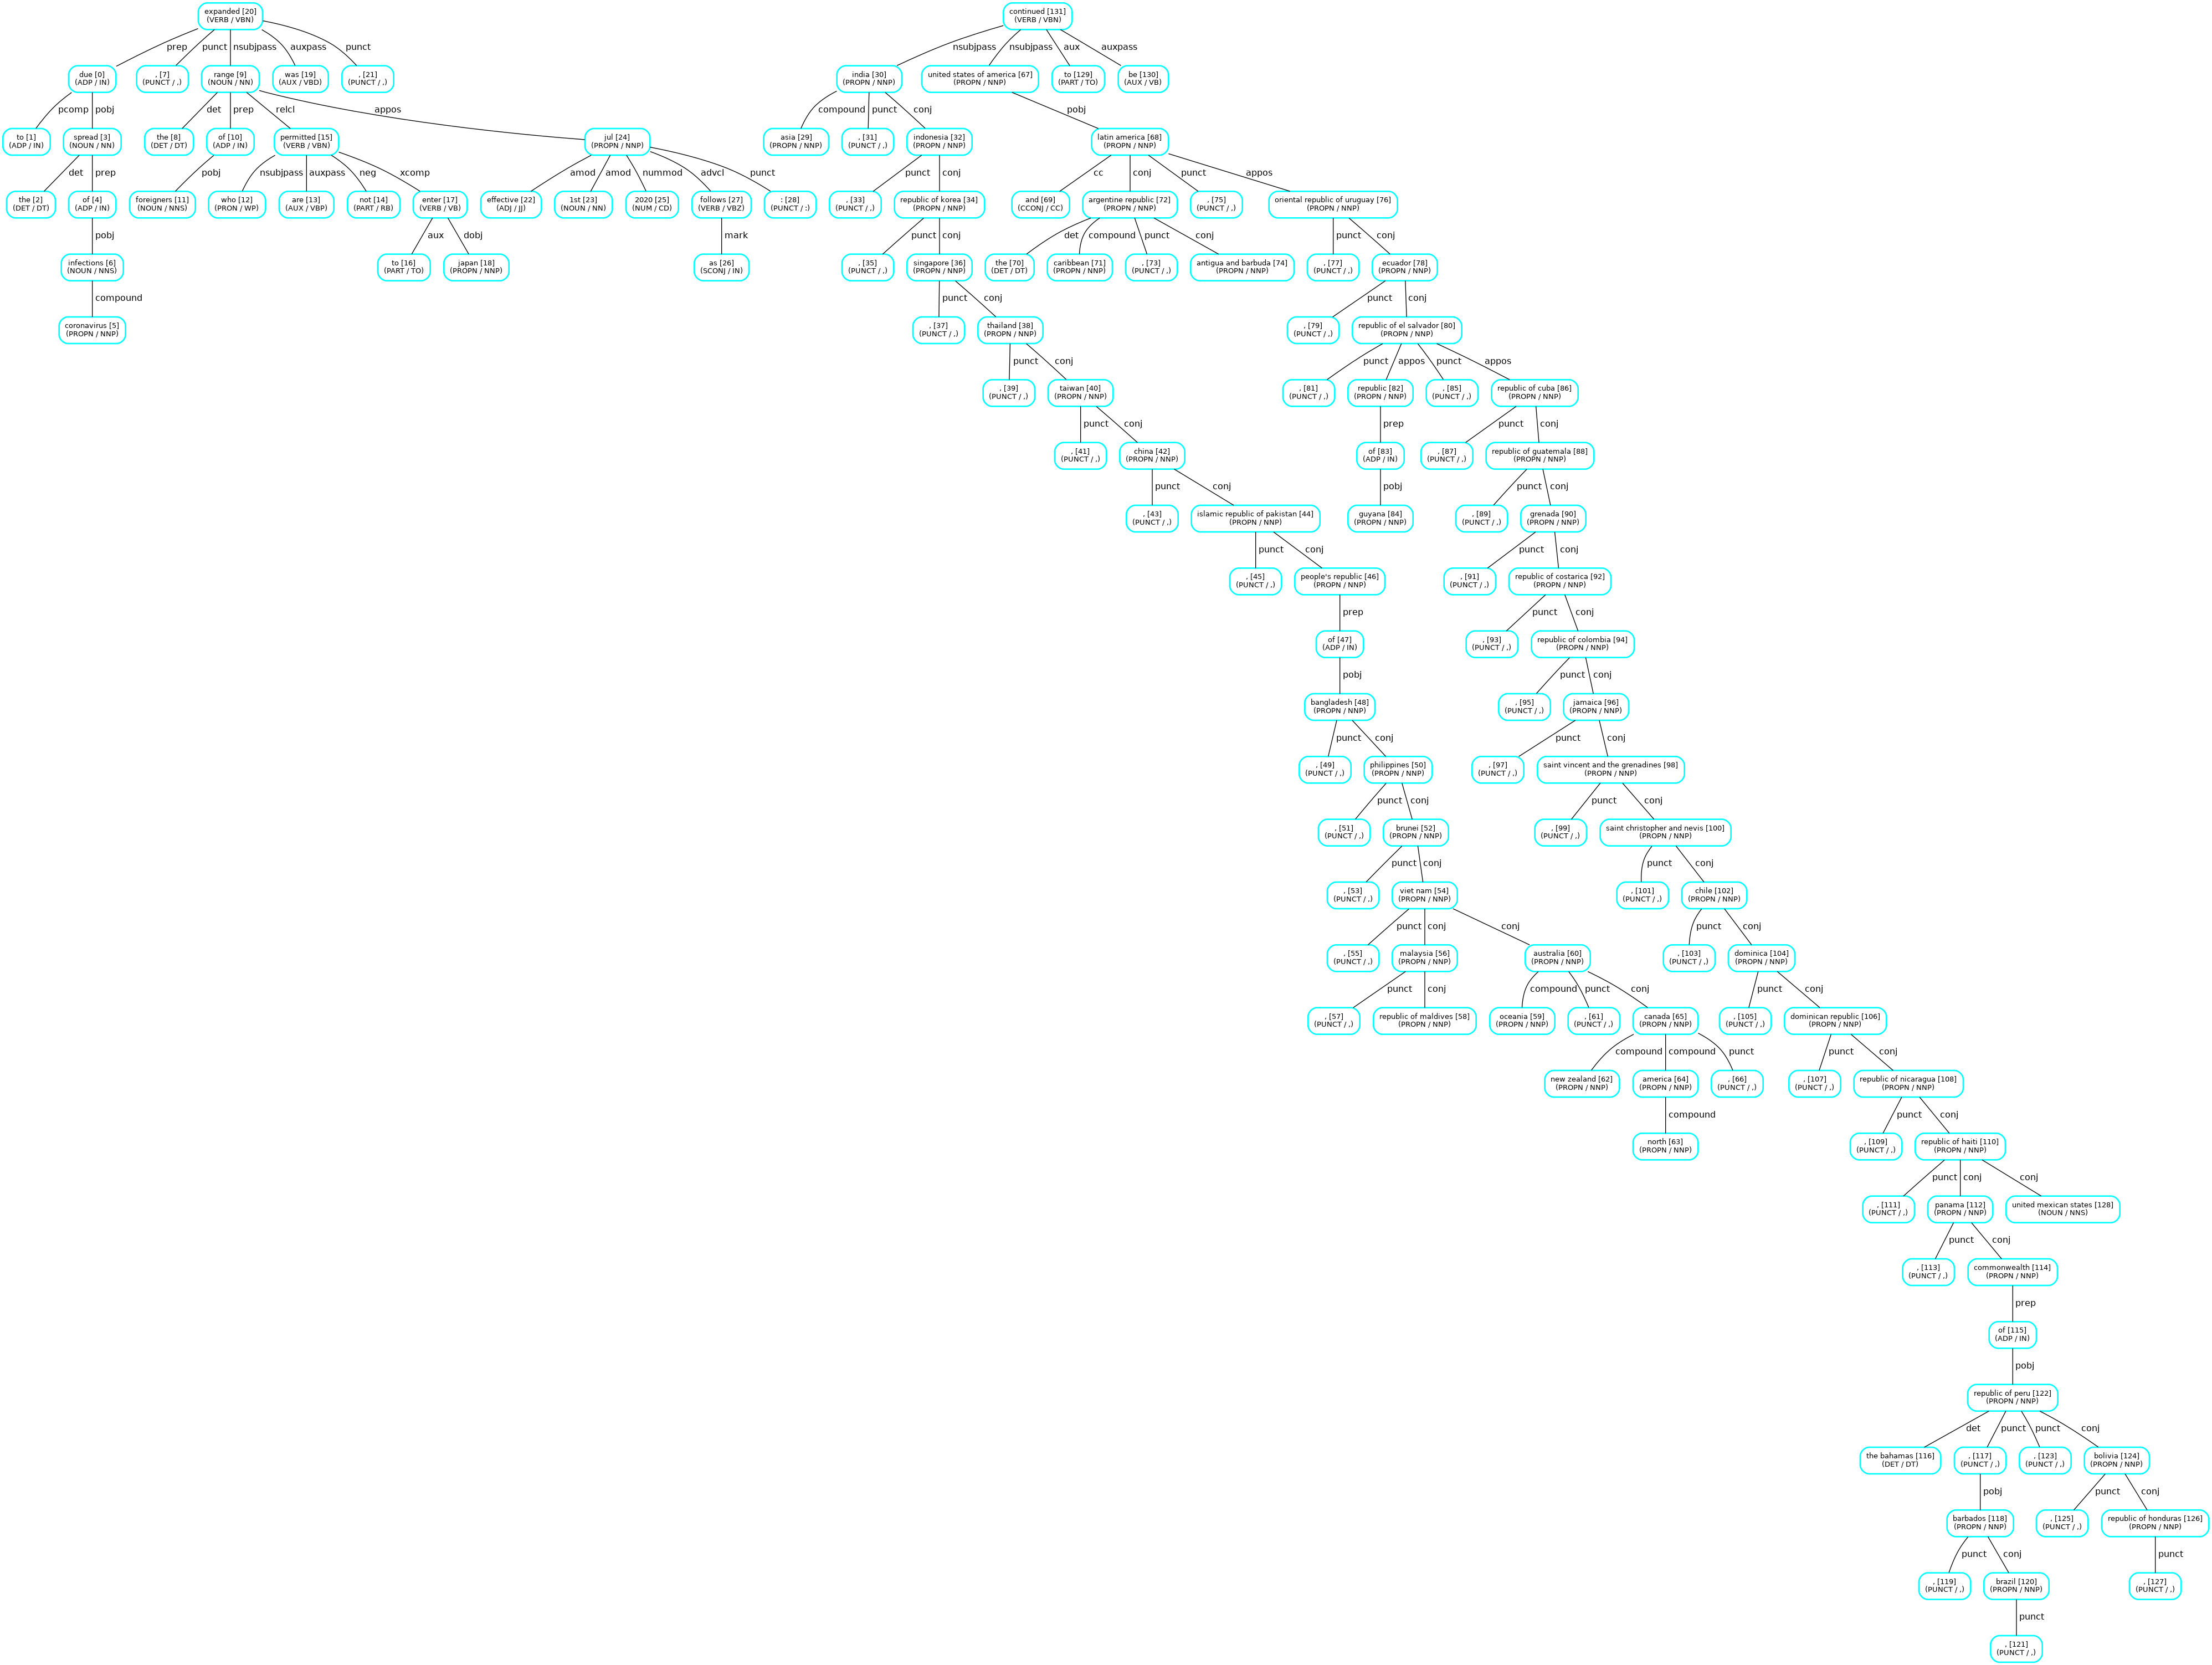

In [18]:
img_ = visualise_spacy_tree.create_png(doc1)
display(Image(img_))

### 2. Extract the meaning of the sentence


Identify if the countries mentioned in the document are allowed or not allowed.

Since country level restrictions are mostly taken by the Government, we consider NOTAMS from airspace rather than airport as they have a wider coverage

Steps carried out:

1. Load the airspace dataset

2. Preprocess the text to extend abbreviations, remove hyperlinks, foreign text but leave the punctuations as we do sentence tokenisation

3. Identify commonly used nouns, verbs, noun chunks and special adverbs such as "other than",etc. 

4. Create rules to extract the intent of the sentence. For example using the verb/noun mentioned in the sentence identify if the sentence is about closed to countries or open to countries
   Once the intent is determined then extract the countries mentioned in the sentence
   
5. Add the results to a table and then visualise it

Load the airspace dataset

In [19]:
asp_active_df = pd.read_csv("/project_data/data_asset/valid_airspace_notams_20200715.csv")

In [20]:
asp_active_df.head()

,message,Qcode,createdDate,Closed,FIRcode,FIRname,countryCode,countryName,tokens,cleaned_message
0,COVID-19:REF E-AIP INDIA ENR 1.9 PARA 15.4.3.3...,XXXX,2020-07-02 08:46:00+00:00,False,VABF,MUMBAI,IND,India,"['covid', 'refernce', 'aeronautical', 'informa...",covid 19 refernce to e aeronautical informatio...
1,COVID-19: IN ORDER TO RESTRICT THE SPREAD OF C...,XXXX,2020-07-03 11:04:00+00:00,False,VABF,MUMBAI,IND,India,"['covid', 'order', 'restrict', 'spread', 'covi...",covid 19 in order to restrict the spread of co...
2,COVID-19: 1. OPERATION OF REMOTELY PILOTED AIR...,XXXX,2020-06-26 08:14:00+00:00,False,VABF,MUMBAI,IND,India,"['covid', 'operation', 'remotely', 'pilot', 'a...",covid 19 1 operation of remotely piloted aircr...
3,DUE TO THE IMPACT ON THE AIR TRAFFIC DEMAND CA...,XXXX,2020-07-10 15:23:00+00:00,False,SBAZ,AMAZONICA,BRA,Brazil,"['impact', 'air', 'traffic', 'demand', 'cause'...",due to the impact on the air traffic demand ca...
4,DUE TO THE IMPACT ON THE AIR TFC DEMAND CAUSED...,XXXX,2020-06-26 19:35:00+00:00,False,SBAZ,AMAZONICA,BRA,Brazil,"['impact', 'air', 'traffic', 'demand', 'cause'...",due to the impact on the air traffic demand ca...


Preprocess the text to extend abbreviations, remove hyperlinks, foreign text but leave the punctuations as we do sentence tokenisation

In [21]:
# Adding stop words
new_stop_words = ["create","source","euecyiyn",'etczyoyx','tel']

# Add airport codes to stop words
#new_stop_words.extend([ac.lower() for ac in list(apt_covid_notam_lt_df.airportCode.values)])


for new_word in new_stop_words:
    nlp.vocab[new_word].is_stop = True

mapping = {"acc": "area control", "acft": "aircraft", "ad": "aerodrome", "aic": "aeronautical information circular",
           "aip": "aeronautical information publication", "ais": "aeronautical information services",
           "alt": "altitude", "altn": "alternate", "ap": "airport", "aro": "air traffic services reporting office",
           "arr": "arrival", "atc": "air traffic control", "ats": "air traffic services", "attn": "attention",
           "auth": "authorized", "avbl": "available", "bfr": "before", "cat": "category", "chg": "change","civ":"civil",
           "clsd": "closed", "cov": "cover", "cta": "control area", "ctc": "contact", "ctr": "control zone",
           "dem.": "democratic", "dep": "depart", "emerg": "emergency", "enr": "en route", "exc": "except",
           "fed.": "federation", "fir": "flight information region", "fis": "flight information service",
           "flt": "flight", "flts": "flights", "flw": "follows", "fm": "from", "fpl": "filed flight plan",
           "fri": "friday", "gen": "general", "hr": "hour", "intl": "international", "isl.": "islands",
           "ldg": "landing", "mil": "military", "mon": "monday", "op": "operation","ops": "operations", 
           "opr": "operating","pax": "passenger",
           "ppr": "prior permission required", "ref": "refernce to", "rep.": "republic", "req": "request",
           "rffs": "rescue and fire fighting services", "rmk": "remark", "rte": "route", "rwy": "runway",
           "sat": "saturday", "ser": "service", "svc": "service message", "taf": "terminal aerodrome forecast",
           "tfc": "traffic", "thu": "thursday", "tma": "terminal control area", "tue": "tuesday",
           "twr": "aerodrome control tower", "vfr": "visual flight rules"}

In [22]:
def clean_message_keep_punct(message):
    #############################
    ## mapping, lower, language #
    #############################
    #Make everything to lower case
    message = row['message'].lower().strip()
    message = re.sub(r'(http|https|www)\S+', '', message)
    
    # Mapping short terms to actual word
    for s_, w in mapping.items():
        message = re.sub(r'\b{}\b'.format(s_),w,message)
    
    # If a country has NOTAMs in two languages, the english text starts with the phrase "english text/english version"
    if "english text" in message:
        #print("TEXT")
        e_t = []
        for m_ in message.split("english text"):
            for sent_ in sent_tokenize(m_):
                if detect(sent_) == "en":
                    e_t.append(sent_)
        message = "".join(e_t)

    elif "english version" in message:
        #print("VERSION")
        e_t = []
        for m_ in message.split("english version"):
            for sent_ in sent_tokenize(m_):
                if detect(sent_) == "en":
                    e_t.append(sent_)
        
        message = "".join(e_t)
        #message = message.split("english version")[1]
    elif detect(message) != "en":
        message = ""

    #Start of string other than character or digit
    #message = re.sub(r'[^ 0-9a-z]', ' ', message)
    #message = message.translate(message.maketrans('', '', string.punctuation)) #extra punctuations removal
    message = re.sub("[\(\[].*?[\)\]]", "", str(message))
    
    # Replace numbered points with comma
    message = re.sub("(\s\d+\.)",", ", str(message))
    # Remove unnecessary white space
    message = " ".join(message.split())
    
    return message

In [23]:
asp_active_df['cleaned_message_with_punct'] = None

for idx,row in asp_active_df.iterrows():
    if row['message'] is not None:
        message = row['message']
        
        message_ = clean_message_keep_punct(message)
        
        asp_active_df.at[idx,"cleaned_message_with_punct"] = message_

**Identify commonly used nouns, verbs, noun chunks and special adverbs such as "other than",etc.**

- This task was done by manually reading through the messages to identify the commonly used phrases and words such as "all borders", "other than"
- The commonly used nouns and verbs were determined using tags and counter
- Once identified we group the verbs and nouns to two categories: positive and negative
- To identify complete closure of airports we identify the commonly used nouns and noun chunks
- In some cases the message talks about some exception for restrictions using some phrases such as "this does not apply", etc. In such cases we don't label the restriction as "open"/"close" rather leave it as "na". 

NOTE:
 - So in cases where the clear intent of restriction (open/close) is not known we label the restriction as "na" denoting "not known". Only the country names mentioned in the NOTAMs are extracted
 
 - Only for messages where one of the following nouns/verbs are used are only covered. So not all messages' information are extracted.

In [24]:
pos_verbs_to_filter = ["permit","allow", "accept","open","lift","exempt"]
neg_verbs_to_filter = ["ban", "exclude", 
                   "refuse","expel", "deny", "prohibit", "cancel","suspend","close","forbid"]
restrict_verb = ["restrict"]

neg_nouns = ["suspension","cancellation","ban"]
pos_nouns = ["opening","enter","resumption","exemption","exempt","alleviation"]

# If the country border is closed to all countries the following nouns and noun_chunks are commonly used
nouns_to_filter = ["passenger", "foreigner", "traveller", "flight","airport","arrival","departure"]
noun_chunks_ = ["all borders","all flights","civil flight","civil flights","all airports","the border","general aviation","ga","commercial flights","all international"]

na_extension = ["shall hold a negative covid-19 test","unless belong to one of the following","this does not apply"]

**Create Rules**


1. use phrase matcher!

        <nouns> from <GPE> are <verbs> to land <GPE>
 
2. Look for verbs of interest:

        1. Filter for sentences
        2. Check if verbs match
        3. Get GPEs
        4. See if words such as other than, except are present!

**Identify complete closure to international flights**

* Check if the nouns or noun_chunks mentioned earlier is present in the message.

**Identification of airport close/open to specific countries**

* Check if positive/negative verbs are present 
* Check if positive/negative nouns are present 
* Check if negation is associated with the verb/noun
* Identify exceptions in the sentences 
* Extract the country mention in the message
* Associate the identified tag (open/close/na) with the countries mentioned in the message


NOTE:

* As mentioned earlier, not all messages' restrictions are labelled. In cases where no foreign country name is mentioned, the exact level of restriction is not extracted unless one of the commonly used nouns are present in the message!

* In cases where the exact restriction is not known or if the restriction has some conditions such as travellers should undergo covid test or should be citizens, etc then we classify those restrictions as "na"

The following are some of the examples that are identified using the rules:

In [25]:
ex1 = nlp("- khartoum airport will accept flights as its frequency from egypt, uae, and turkey .")
spacy.displacy.render(ex1, style="ent", jupyter=True)

**In the above sentence, the airport is identified as "open" to Egypt, UAE and Turkey**

In [26]:
ex1 = nlp("passenger restrictions: all flight arriving/departing to/from italy must comply with the requirements of the president of the ministerial council of 11 jun, flight to/from states and territories other than - member states of the european union - member states of the schengen agreement - united kingdom of great britain and northern ireland - andorra, principaly of monaco - republic of san marino and vatican city state are still prohibited till 30/06/2020 for those flights prohibited exceptions are reported in art 6 of the same decree")
spacy.displacy.render(ex1, style="ent", jupyter=True)

In [29]:
{'GBR': 'open', 'AND': 'open', 'MCO': 'open', 'SMR': 'open', 'VAT': 'open', 'NEUM': 'close', 'NSCH': 'close'}

{'GBR': 'open',
 'AND': 'open',
 'MCO': 'open',
 'SMR': 'open',
 'VAT': 'open',
 'NEUM': 'close',
 'NSCH': 'close'}

**In the above sentence,the rules identify Italy is closed to Non-EU and Non-Schengen and open to Andorra, Monaco, San Marino and Vatican city**

In [28]:
ex1 = nlp("all international flights from or to morocco are suspended until further notice except over flight and cargo.")
spacy.displacy.render(ex1, style="ent", jupyter=True)

**In the above sentence, since the noun chunk "all international" is associated with the verb "suspended"- the rules identify Morocco is closed to all countries**

An example where the rules fail to identify the restriction is shown below:

In [30]:
asp_active_df[asp_active_df.countryCode=='IND'].loc[1]['cleaned_message_with_punct']

'covid-19: in order to restrict the spread of covid-19 disease in india, following restrictions are imposed on all scheduled indian and foreign airlines engaged in international air transportation to/from india:, no scheduled international commercial passenger aircraft shall take off from any foreign airport for any airport in india after 0001 utc of 22 mar 2020 till 1829 utc of 31 jul, , these instructions are in addition to the travel restrictions/advisories already issued and under implementation., the restrictions do not apply to aircraft operated in the following circumstances: - aircraft in a state of emergency - at alternate aerodromes identified in a flight plan - cargo flights - technical landings where passengers do not disembark, operations related to humanitarian aid, medical supplies or relief flights will need approval from director general of civil aviation, india. this will require coordination between the diplomatic representatives from concerned country in india and t

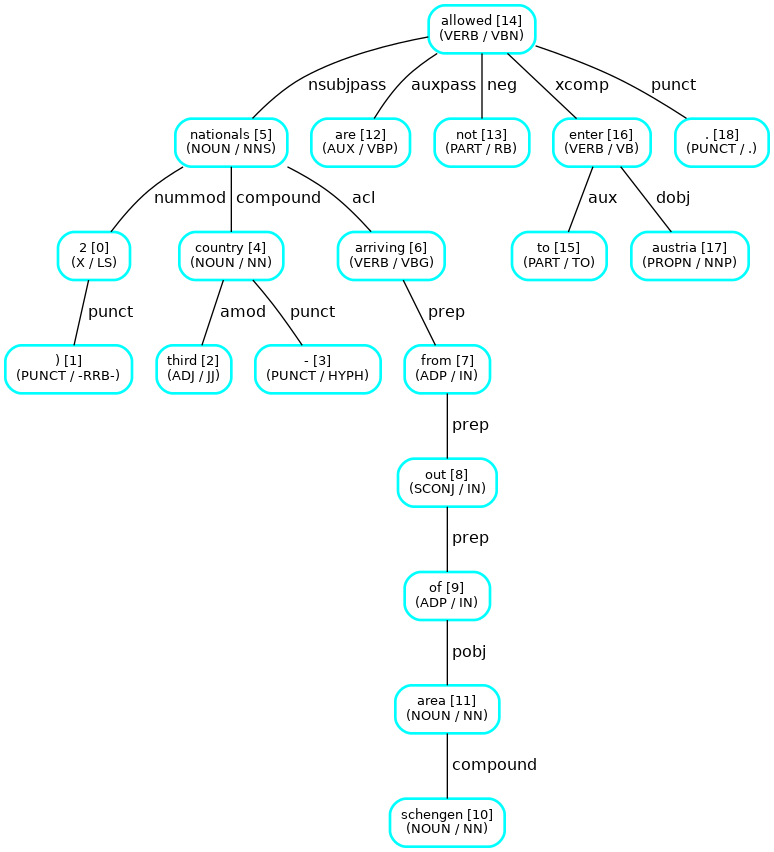

In [31]:
d1 = nlp("2) third-country nationals arriving from out of schengen area are not allowed to enter austria.")
img_ = visualise_spacy_tree.create_png(d1)
display(Image(img_))

In [ ]:
def all_country_closure(c):
    '''
    look for the nouns and identify if the word "all" is associated with it. 
    Then label the restriction as "all" countries
    '''
    countries = []
    if (c.lemma_ == "to") | (c.lemma_ == "for")| (c.lemma_ == "from"):
        for c_ in c.children:
            if c_.lemma_ in nouns_to_filter:
                for c__ in c_.children:
                    if c__.lemma_ == "all":
                        countries = "all"
    if c.lemma_ in nouns_to_filter:
        for c_ in c.children:
            if c_.lemma_ == "all":
                countries = "all"
    #print(countries)
    if len(countries) != 0:
        return countries
    else:
        return None

each_country = dict()
for cc in asp_active_df.countryCode.unique():#['ITA']:#
    master_dict= dict()
    each_country[cc] = []
    relevant_messages = []
    print(cc)
    for idx, r in asp_active_df[asp_active_df.countryCode==cc].iterrows():
        
        current_country = r['countryCode']

        doc = nlp(r['cleaned_message_with_punct']) 
        
        # Get all country names mentioned in the message
        other_countries = [t.ent_id_ for t in doc if (t.ent_type_ == "GPE") & (t.ent_id_ != '') & (t.ent_id_ != current_country)]

        #nltk sent tokenise is better
        for sent_ in sent_tokenize(doc.text):
            doc_ = nlp(sent_)
        #for doc_ in doc.sents:
            tag = []
            tag_single = ""
            countries = []
            countries_dt = {}

            for t in doc_:
                # If one of the positive verbs is present then we tag it as open unless a negation is present in the children
                if ((t.pos_ == "VERB") & (t.lemma_ in pos_verbs_to_filter)):
                    tag_ = "open"
                    # if negation is present in one of the children associated with the verb we invert the tag
                    for c_ in t.children:
                        if c_.dep_ == "neg":
                            tag_ = "close"
                        #print(c_)
                        countries_ = all_country_closure(c_)
                        if countries_ is not None:
                            countries.append(countries_)
                            countries_dt[countries_] = tag_
                    tag.append(tag_)
                    tag_single = tag_

                # If one of the negative verbs is present then we tag it as close unless a negation is present in the children
                elif ((t.pos_ == "VERB") & (t.lemma_ in neg_verbs_to_filter)):
                    tag_ = "close"
                    # if negation is present in one of the children associated with the verb we invert the tag
                    for c_ in t.children:
                        if c_.dep == "neg":
                            tag_ = "open"

                        countries_ = all_country_closure(c_)
                        #print(countries_)
                        if countries_ is not None:
                            countries.append(countries_)
                            countries_dt[countries_] = tag_
                    tag.append(tag_)
                    tag_single = tag_

                # If one of the positive nouns is present then we tag it as open unless a negation is present in the children
                if ((t.pos_ == "NOUN") & (t.lemma_ in pos_nouns)):
                    tag_ = "open"
                    # if negation is present in one of the children associated with the noun we invert the tag
                    for c_ in t.children:
                        if c_.dep_ == "neg":
                            tag_ = "close"
                        countries_ = all_country_closure(c_)
                        if countries_ is not None:
                            countries.append(countries_)
                            countries_dt[countries_] = tag_
                    tag.append(tag_)
                    tag_single = tag_

                # If one of the negative nouns is present then we tag it as close unless a negation is present in the children
                elif ((t.pos_ == "NOUN") & (t.lemma_ in neg_nouns)):
                    tag_ = "close"
                    # if negation is present in one of the children associated with the verb we invert the tag
                    for c_ in t.children:
                        if c_.dep == "neg":
                            tag_ = "open"
                        countries_ = all_country_closure(c_)
                        if countries_ is not None:
                            countries.append(countries_)
                            countries_dt[countries_] = tag_
                    tag.append(tag_)
                    tag_single = tag_

                if ((t.pos_ == "VERB") & (t.lemma_ in restrict_verb)):
                    tag_ = 'restrict'
                    tag.append('restrict')
                    tag_single = tag_
                
                # In cases where the complete restriction is mentioned using one of the noun chunks we identify those mentions and then label the restriction to "all" countries
                for current_nc in doc_.noun_chunks: 
                    for nc_ in noun_chunks_:
                        if nc_ == current_nc.text:
                            for vs in current_nc.root.ancestors:
                                if ((vs.pos_ == "VERB")& ((t.lemma_ in pos_verbs_to_filter)| (t.lemma_ in pos_verbs_to_filter))):
                                    countries.append("all")
                                    countries_dt["all"] = tag_single
                                if ((vs.pos_ == "NOUN")& ((t.lemma_ in pos_nouns)| (t.lemma_ in neg_nouns))):
                                    countries.append("all")
                                    countries_dt["all"] = tag_single
            
            # In some messages the word "non" is used to denote negation for countries. These mentions are identified and the tag is inverted
            for ix,sus_c in enumerate(doc_):
                if (sus_c.ent_type_=="GPE")&(sus_c.ent_id_ != '')& (sus_c.ent_id_ != current_country):
                    country_prefix = ''
                    for ix_ in range(ix-5,ix):
                        # Negation for NON mentions
                        if (doc_[ix_].lemma_ == "non"):
                            if sus_c.ent_id_ in ['EUM','SCH']:
                                country_prefix = "N"
                            else:
                                country_prefix = "negate"
                    if country_prefix == "N":
                        countries.append('N'+sus_c.ent_id_)
                        countries_dt['N'+sus_c.ent_id_] = tag_single#f_tag
                    elif country_prefix == "negate":
                        countries.append(sus_c.ent_id_)
                        if tag_single == "open":
                            countries_dt[sus_c.ent_id_] = "close"#f_tag
                        elif tag_single == "close":
                            countries_dt[sus_c.ent_id_] = "open"
                        else:
                            countries_dt[sus_c.ent_id_] = "na"
                    else:
                        countries.append(sus_c.ent_id_)
                        if tag_single == "open":
                            countries_dt[sus_c.ent_id_] = "open"#f_tag
                        elif tag_single == "close":
                            countries_dt[sus_c.ent_id_] = "close"
                        else:
                            countries_dt[sus_c.ent_id_] = "na"

            # Negation for exceptions
            # Tag is inverted for countries that precede with one of the following words: except, exception, outside, out, other, unless
            negation_countries =[]
            for idx,s in enumerate(doc_):
                if (s.lemma_ =="except")|(s.lemma_ == "exception")|(s.lemma_ == "outside")|(s.lemma_ == "out")|(s.lemma_ == "other")|(s.lemma_ == "unless"):
                    for _ in range(idx+1,idx+15):
                        #print(_)
                        try:
                            if (doc_[_].ent_type_=="GPE")&(doc_[_].ent_id_ != '')& (doc_[_].ent_id_ != current_country):
                                for child in doc_[_].subtree:
                                    if (child.ent_type_=="GPE")&(child.ent_id_ != '')& (child.ent_id_ != current_country):
                                        # print(child,child.ent_id_,countries_dt[child.ent_id_])
                                        negation_countries.append(child.ent_id_)
                        except Exception as e:
                            pass
                            #print(str(e))
            if len(negation_countries) > 0:
                #print("NEGATION")
                for neg_country in set(negation_countries):
                    if ("EUM" in neg_country)|("SCH" in neg_country):
                        countries_dt["N"+ neg_country] = countries_dt[neg_country]
                        del countries_dt[neg_country]
                    elif countries_dt[neg_country] == 'open':
                        countries_dt[neg_country] = 'close'
                    elif countries_dt[neg_country] == 'close':
                        countries_dt[neg_country] = 'open'
                    else:
                        countries_dt[neg_country] == 'na'

            #if the exact intent of the restriction is uncles tag it as "na"
            for s in na_extension:
                    if s in doc_.text:
                        tag.append("na")

            # To overocme contradicting messages we set the flag to na
            if (len(set(tag)) >1) &(len(countries_dt.keys()) > 0):
                for key_, value_ in countries_dt.items():
                    countries_dt[key_] = "na"

            if  len(countries_dt.keys()) > 0 :
            #if tag != "na":
                print(doc_.text)
                spacy.displacy.render(doc_, style="ent", jupyter=True)
                print("Tag: {}".format(tag))
                print("Countries affected: {}".format(countries))
                print("Countries affected dict: {}".format(countries_dt))
                #print("tags - {}".format(f_tag))
                print("tag single - {}".format(tag_single))
                print("Home country: {}, {}, {}".format(r['countryCode'], r['countryName'], r['Qcode']))
                print("----")

            # consolidate the restrictions by country
            if len(countries_dt.keys()) > 0 :
                each_country[cc].append(countries_dt)
                #relevant_messages.append(doc_.text)
    

Converting the results to a dataframe:

- As we are extracting the information from each sentence, some countries might have contradicting tags (both open and close associated to the same country. 
  In such cases we simply label the restriction as "1"(restriction) if regions such as EU, Scandinavia or as "2" (special) for country specific mention

- The restriction levels used are given below:

    * 4  - home
    * 3  - open 
    * 2  - special
    * 1  - restriction
    * 0  - close

In [33]:
#each_country['PRT']
master_dict = dict()
for main_c in each_country.keys():
    master_dict[main_c] = dict()
    for dt in each_country[main_c]:
        for k,v in dt.items():
            if not k in master_dict[main_c].keys():
                master_dict[main_c][k] = []
            master_dict[main_c][k].append(v)

In [34]:
for country__ in master_dict.keys():
    if (len(master_dict[country__].keys()) > 1) & ('all' in master_dict[country__].keys()):
            master_dict[country__].pop("all")

In [35]:
res_dt = dict()

for k in master_dict.keys():
    res_dt[k] = dict()
    european_c_ = list(set(european_regions).intersection(set(master_dict[k].keys())))
    if len(european_c_) > 0:
        for e_c_ in european_c_:
            countries = european_regions_dt[e_c_]
            for ec_ in countries:
                #if :
                #    res_dt[k][ec_] = -1#"conditions" #-1#
                if set(master_dict[k][e_c_]) == {'open'}:
                    res_dt[k][ec_] = 3#"open" #1#
                elif set(master_dict[k][e_c_]) == {'close'}:
                    res_dt[k][ec_] = 0#"close" #0#
                elif (set(master_dict[k][e_c_]) == {"na"})|(set(master_dict[k][e_c_]) == {"restrict"})|(len(set(master_dict[k][e_c_])) > 1):
                    res_dt[k][ec_] = 1#"other" #-2#


    if "all" in master_dict[k].keys():
        for all_c in all_countries['Alpha-3 code'].unique():
            #if :
            #    res_dt[k][all_c] = -1#"conditions" #-1#
            if set(master_dict[k]["all"]) == {'open'}:
                res_dt[k][all_c] = 3#"open" #1#
            elif set(master_dict[k]["all"]) == {'close'}:
                res_dt[k][all_c] = 0#"close" #0#
            elif (set(master_dict[k]["all"]) == {"na"})|(set(master_dict[k]["all"]) == {"restrict"})|(len(set(master_dict[k]["all"])) > 1):
                res_dt[k][all_c] = 1#"other" #-2#

            #restrictions_dict[cc][all_c]['message'].append(relevant_messages)

    for sub_o in master_dict[k].keys():
        if (sub_o not in european_regions) &(sub_o != 'all'):
            #if len(set(master_dict[k][sub_o])) > 1:
            #    res_dt[k][sub_o] = 2#"special" #2#
            if set(master_dict[k][sub_o]) == {'open'}:
                res_dt[k][sub_o] = 3#"open" #1#
            elif set(master_dict[k][sub_o]) == {'close'}:
                res_dt[k][sub_o] = 0#"close" #0#
            elif (set(master_dict[k][sub_o]) == {"na"})|(set(master_dict[k][sub_o]) == {"restrict"}) |(len(set(master_dict[k][sub_o])) > 1) :
                res_dt[k][sub_o] = 2
            #elif (set(master_dict[k][sub_o]) == {"na"})|(set(master_dict[k][sub_o]) == {"restrict"}):
            #    res_dt[k][sub_o] = -2#"other" #-2#
            #restrictions_dict[cc][k]['message'].append(relevant_messages)
    res_dt[k][k] = 4#'home' #3#
    res_dt[k]['XYZ'] = 0

In [36]:
res_df = pd.DataFrame(res_dt)

In [37]:
res_df

,IND,BRA,HND,SVK,BOL,DEU,SAU,VNM,ARG,TUR,...,URY,ETH,THA,CHE,IRL,BHR,TJK,GRC,SVN,LAO
ABW,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
AFG,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
AGO,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
AIA,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
ALB,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
AND,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
ARE,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
ARG,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,4.0,3.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0.0,NaN,NaN
ARM,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0.0,NaN,NaN
ASM,NaN,NaN,0.0,NaN,1.0,1.0,0.0,NaN,NaN,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN


Convert the dataframe to suit to be displayed on a dashboard

In [38]:
closure_df = pd.DataFrame()
for col_c in res_df.columns:
    
    df_ = pd.DataFrame(res_df[col_c])
    df_['home'] = col_c
    df_.reset_index(inplace=True)
    df_.rename(columns={'index':'other',col_c:'restriction'},inplace=True)
    closure_df = pd.concat([closure_df,df_])

In [39]:
closure_df[closure_df.home=='CAN']['restriction'].value_counts()

2.0    2
0.0    1
4.0    1
Name: restriction, dtype: int64

In [40]:
closure_df.to_csv("/project_data/data_asset/country_closure_20200716.csv",index=False)

**Next Steps**

* Improve the results of information extraction

* Annotate the message to extract other information such as cargo restrictions, etc

**Author**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce